In [1]:
import baseline
import numpy as np
import commpy as cp
from signal_generator import SignalGenerator

# Visualization
import pylab
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()  # Use seaborn as backend of matplotlib for vis

## Define Paramters for comparision and Data generator

In [36]:
class Params:
    SNR_RANGE = range(-10, 30, 10) 
    BPSK_M, QPSK_M, QAM16_M, QAM64_M = (2, 4, 16, 64)
    
modem = cp.modulation.QAMModem(Params.QAM64_M)
generator = SignalGenerator(modem=modem)

## Evaluate Baseline on multiple SNRs

4it [00:35,  8.81s/it]


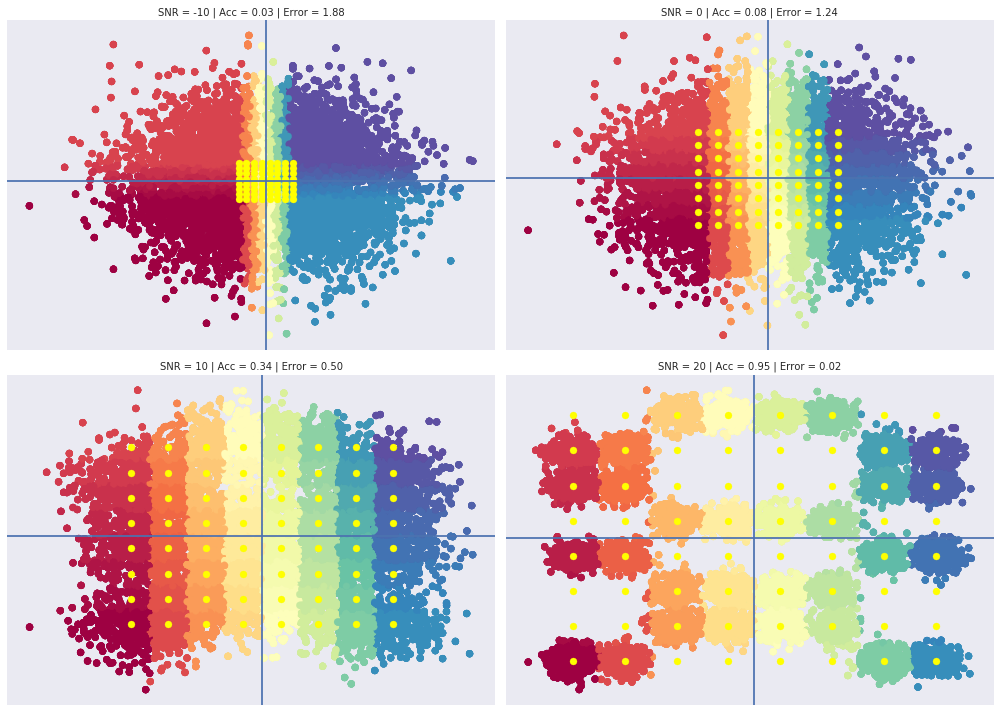

In [39]:
import tqdm

NUM_SAMPLES = 1000
BLOCK_LENGTH = 100

baseline_original_bits = []
baseline_preds = []
baseline_errors = []
baseline_accuracy = []

fig, axes = plt.subplots(2, len(Params.SNR_RANGE) // 2, figsize=(14, 10))
for i, snr in tqdm.tqdm(enumerate(Params.SNR_RANGE)):
    ax = axes.reshape(-1)[i]
    (original_bits, clean_signals, noisy_signals) = \
        generator(NUM_SAMPLES, BLOCK_LENGTH, snr_in_dB=snr)

    preds = baseline.optimal_demodulator(noisy_signals.flatten(), modem.constellation)
    labels = baseline.optimal_demodulator(clean_signals.flatten(), modem.constellation)
    
    visualize(noisy_signals.flatten(), modem.constellation, ax=ax, predictions=preds)
    
    acc, err = baseline.get_scores(preds, labels)
    ax.set_title('SNR = {} | Acc = {:.2f} | Error = {:.2f}'.format(snr, acc, err), fontsize=10)
    
    baseline_original_bits.append(original_bits)
    baseline_preds.append(preds)
    baseline_errors.append(err)
    baseline_accuracy.append(acc)
    
fig.tight_layout()

## Evaluate Neural Demod on multiple SNRs

### 1. Load pre-trained model

### 2. Evaluate Neural Demod

4it [00:38,  9.56s/it]


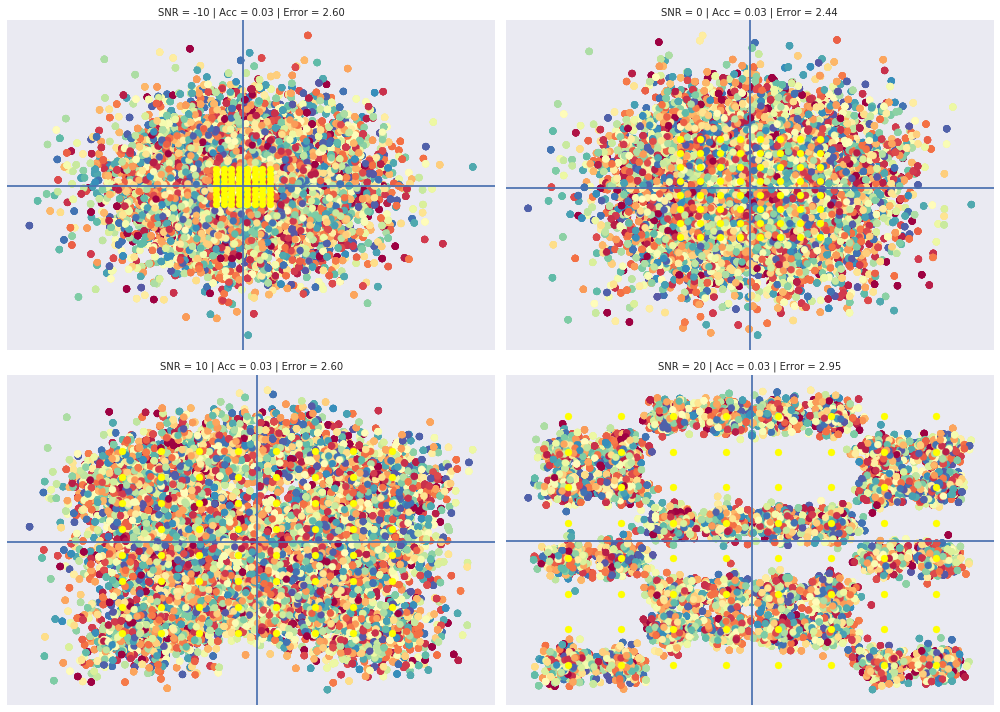

In [71]:
modular_nn_original_bits = []
modular_nn_preds = []
modular_nn_errors = []
modular_nn_accuracy = []

fig, axes = plt.subplots(2, len(Params.SNR_RANGE) // 2, figsize=(14, 10))
for i, snr in tqdm.tqdm(enumerate(Params.SNR_RANGE)):
    ax = axes.reshape(-1)[i]
    (original_bits, clean_signals, noisy_signals) = \
        generator(NUM_SAMPLES, BLOCK_LENGTH, snr_in_dB=snr)
    
    X_test, Y_test = get_trainable_data(noisy_signals, clean_signals)
    predictions = np.argmax(model.predict(X_test), -1)
    labels = baseline.optimal_demodulator(clean_signals.flatten(), modem.constellation)
    
    visualize(noisy_signals.flatten(), modem.constellation, ax=ax, predictions=preds)
    
    acc, err = baseline.get_scores(predictions, labels)
    ax.set_title('SNR = {} | Acc = {:.2f} | Error = {:.2f}'.format(snr, acc, err), fontsize=10)
    
    modular_nn_original_bits.append(original_bits)
    modular_nn_preds.append(preds)
    modular_nn_errors.append(err)
    modular_nn_accuracy.append(acc)
    
fig.tight_layout()